##  EXPERIMENT USING STARS, EXOPLANETS AND QUASARS


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix


## checking for missing/null values (extra caution before starting the new experiment)

In [3]:
# dealing with any missing/null values for stars, exopalnets and quasars datasets 
stars_df = pd.read_csv("../../data/full/stars_gaia_clean.csv")
print(stars_df.isnull().sum())
print(stars_df.info())

exo_df = pd.read_csv("../../data/full/exoplanets_clean.csv")
print(exo_df.isnull().sum())
print(exo_df.info())

quasars_df = pd.read_csv("../../data/full/quasars_gaia_clean.csv")
print(quasars_df.isnull().sum())
print(quasars_df.info())

source_id          0
ra                 0
dec                0
parallax           0
pmra               0
pmdec              0
phot_g_mean_mag    0
bp_rp              0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   source_id        50000 non-null  int64  
 1   ra               50000 non-null  float64
 2   dec              50000 non-null  float64
 3   parallax         50000 non-null  float64
 4   pmra             50000 non-null  float64
 5   pmdec            50000 non-null  float64
 6   phot_g_mean_mag  50000 non-null  float64
 7   bp_rp            50000 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 3.1 MB
None
rowid              0
pl_name            0
hostname           0
pl_letter          0
gaia_id            0
discoverymethod    0
disc_year          0
pl_orbper          0
pl_orbsmax         0
st_teff

## Loading Data 


In [4]:
# Laad datasets
stars_df = pd.read_csv("../../data/full/stars_gaia_clean.csv").assign(label="star")
exo_df = pd.read_csv("../../data/full/exoplanets_clean.csv").assign(label="exo_host")
quasars_df = pd.read_csv("../../data/full/quasars_gaia_clean.csv").assign(label="quasar")


#align column: exo use sy_plx while stars and qiuasars use parallax
exo_df = exo_df.rename(columns={"sy_plx":"parallax", "sy_pmra":"pmra", "sy_pmdec":"pmdec", "sy_gaiamag":"phot_g_mean_mag"})


# select shared features
features = ["ra", "dec", "parallax", "pmdec", "pmra", "phot_g_mean_mag"]

# Define dataset size for each datasets 
sizes = [10000, 20000, 37800]







In [5]:
exo_df = exo_df.dropna(subset=features)


In [6]:
from sklearn.model_selection import train_test_split

# Trim datasets to only have selected features and drop rows with missing values
stars_df = stars_df[features + ["label"]].dropna()
exo_df = exo_df[features +["label"]].dropna()
quasars_df = quasars_df[features + ["label"]].dropna()



# This satcks the three datasets toghether, so i can threat them as a single multiclass dataset
df = pd.concat([stars_df, exo_df, quasars_df])

# Split in X (Numeric Feature only) and y (Call labels (Star, Exoplanet, Quasar)

X = df[features]
y = df["label"]


# labeled-feature datasets only 
subsets = {}

## Creates a balanced subsets for each dataset size
for n_total in sizes:
    n_per = min(n_total // 3, len(stars_df), len(exo_df), len(quasars_df))

    
    stars_sub = stars_df.sample(n=n_per, random_state=42)
    exo_sub = exo_df.sample(n=n_per, random_state=42)
    quasars_sub = quasars_df.sample(n=n_per, random_state=42)

    df_sub = pd.concat([stars_sub, exo_sub, quasars_sub], ignore_index=True)
    X_n = df_sub[features]
    y_n = df_sub["label"]
    subsets[n_total] = (X_n, y_n)



## Baselien sanity (DummyClassifier)
### I have 3 kinds of objects: Stars, Exoplanets, Quasars. 
### See if the model does better than random guessing, so i make a "dummy" model that just guesses in a simple way, and check how bad it is.
### If tha main model beats this dummy, i know im doing real learning.

In [7]:
print(exo_df.columns)
print(exo_df[features].isna().mean().sort_values(ascending=False))
print("exo rows before dropna:", len(exo_df))



Index(['ra', 'dec', 'parallax', 'pmdec', 'pmra', 'phot_g_mean_mag', 'label'], dtype='object')
ra                 0.0
dec                0.0
parallax           0.0
pmdec              0.0
pmra               0.0
phot_g_mean_mag    0.0
dtype: float64
exo rows before dropna: 37871


In [8]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score

X_n, y_n = subsets[10000]

for n in sizes:
    X_n, y_n = subsets[n]

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

accs, f1s = [], []
for train_idx, test_idx in splitter.split(X_n, y_n):
    clf = DummyClassifier(strategy="most_frequent", random_state=42)
    clf.fit(X_n.iloc[train_idx], y_n.iloc[train_idx])
    pred = clf.predict(X_n.iloc[test_idx])
    accs.append(accuracy_score(y_n.iloc[test_idx], pred))
    f1s.append(f1_score(y_n.iloc[test_idx], pred, average="macro"))



print("Dummy most_frequent:", np.mean(accs), np.mean(f1s))



Dummy most_frequent: 0.33333333333333337 0.16666666666666669


## Logistic regression, Random Forest and Multi-layer perception (Main supervised models)

In [ ]:
from sklearn.model_selection import StratifiedKFold

## Main supervised models (LogReg, RF, MPL)


#align column: exo use sy_plx while stars and qiuasars use parallax
exo_df = exo_df.rename(columns={"sy_plx":"parallax", "sy_pmra":"pmra", "sy_pmdec":"pmdec", "sy_gaiamag":"phot_g_mean_mag"})


# select shared features
features = ["ra", "dec", "parallax", "pmdec", "pmra", "phot_g_mean_mag"]

# Define dataset size for each datasets 
sizes = [10000, 20000, 37800]

# Trim datasets to only have selected features and drop rows with missing values
stars = stars_df[features + ["label"]].dropna()
exo = exo_df[features +["label"]].dropna()
quasars = quasars_df[features + ["label"]].dropna()

def eval_size_logreg(n_total, k=5):
    n_per = min(n_total // 3, len(exo), len(stars), len(quasars))
    stars_sub = stars.sample(n=n_per, random_state=42)
    exo_sub = exo.sample(n=n_per, random_state=42)
    quasars_sub = quasars.sample(n=n_per, random_state=42)

    df = pd.concat([exo_sub, stars_sub, quasars_sub], ignore_index=True)
    X = df[features].values
    y = df["label"].values

    # 80% train+val, 20% test
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # K-fold on train+val
    skf= StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    accs, f1s, precs, recs = [], [], [], []
    

    clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000))
    for train_idx, val_idx in skf.split(X_trainval, y_trainval):
        clf.fit(X_trainval[train_idx], y_trainval[train_idx])
        pred = clf.predict(X_trainval[val_idx])

        p, r, f1, _ = precision_recall_fscore_support(
            y_trainval[val_idx], pred, average="macro", zero_division=0
       
        )
        accs.append(accuracy_score(y_trainval[val_idx], pred))
        precs.append(p); recs.append(r); f1s.append(f1)

    #Final test evaluation
    clf.fit(X_trainval, y_trainval)
    test_pred = clf.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    test_p, test_r, test_f1, _ = precision_recall_fscore_support(
        y_test, test_pred, average="macro", zero_division=0

    )
       
        
    return {
        "size": 3 * n_per,
        "cv_acc_mean": np.mean(accs),
        "cv_f1_mean": np.mean(f1s),
        "cv_prec_mean": np.mean(precs),
        "cv_rec_mean": np.mean(recs),
        "test_acc": test_acc,
        "test_prec": test_p,
        "test_rec": test_r,
        "test_f1": test_f1,
    }
  
for size in sizes:
    print(eval_size_logreg(size))

{'size': 9999, 'acc_mean': np.float64(0.9774833333333335), 'f1_mean': np.float64(0.9774779968974233), 'prec_mean': np.float64(0.9775730698823865), 'rec_mean': np.float64(0.9774813544178861), 'train_acc_mean': np.float64(0.9774805183981332), 'test_acc_mean': np.float64(0.9774833333333335), 'acc_gap': np.float64(-2.8149352002682093e-06)}
{'size': 19998, 'acc_mean': np.float64(0.9794500000000002), 'f1_mean': np.float64(0.979446226921007), 'prec_mean': np.float64(0.9794854066130139), 'rec_mean': np.float64(0.9794508159773578), 'train_acc_mean': np.float64(0.9794390965537357), 'test_acc_mean': np.float64(0.9794500000000002), 'acc_gap': np.float64(-1.0903446264420857e-05)}
{'size': 37800, 'acc_mean': np.float64(0.9796869488536154), 'f1_mean': np.float64(0.9796832753779882), 'prec_mean': np.float64(0.9797240999725578), 'rec_mean': np.float64(0.9796869488536156), 'train_acc_mean': np.float64(0.9797001763668434), 'test_acc_mean': np.float64(0.9796869488536154), 'acc_gap': np.float64(1.322751322

## Rendom Forest


In [ ]:

from sklearn.model_selection import StratifiedKFold

##random forest model 
def eval_size_rf(total, k=5):
    n_per = min(total // 3, len(exo), len(stars), len(quasars))
    stars_sub = stars.sample(n=n_per, random_state=42)
    exo_sub = exo.sample(n=n_per, random_state=42)
    quasars_sub = quasars.sample(n=n_per, random_state=42)

    df = pd.concat([exo_sub, stars_sub, quasars_sub], ignore_index= True)
    df[features] = df[features].apply(pd.to_numeric, errors='coerce')
    df = df.dropna(subset=features)

    X = df[features].values
    y = df["label"].values

    #80% train+val, 20% test
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )


    #k-fold on train+val
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    accs, f1s, precs, recs = [], [], [], []
    

    for train_idx, val_idx in skf.split(X_trainval, y_trainval):
        clf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced_subsample")
        clf.fit(X_trainval[train_idx], y_trainval[train_idx])
        y_pred = clf.predict(X_trainval[val_idx])
        p, r, f1, _ = precision_recall_fscore_support(
            y_trainval[val_idx], y_pred, average="macro", zero_division=0
            
        ) 
        accs.append(accuracy_score(y_trainval[val_idx], y_pred))
        precs.append(p); recs.append(r); f1s.append(f1)

    #FInal test evaluation (after CV)
    clf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced_subsample")
    clf.fit(X_trainval, y_trainval)
    test_pred = clf.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    test_p, test_r, test_f1, _ = precision_recall_fscore_support(
        y_test, test_pred, average="macro", zero_division=0
    )
        
     

        

    return {
        "size": 3 * n_per,
        "cv_acc_mean": np.mean(accs),
        "cv_prec_mean": np.mean(precs),
        "cv_rec_mean": np.mean(recs),
        "cv_f1_mean": np.mean(f1s),
        "test_acc": test_acc,
        "test_prec": test_p,
        "test_rec": test_r,
        "test_f1": test_f1,


    }
        
for size in sizes:
    print(eval_size_rf(size))

{'size': 9999, 'acc_mean': np.float64(0.9979833333333333), 'prec_mean': np.float64(0.9979884998035753), 'rec_mean': np.float64(0.9979830905368136), 'f1_mean': np.float64(0.9979832422610725), 'train_acc_mean': np.float64(1.0), 'test_acc_mean': np.float64(0.9979833333333333), 'acc_gap': np.float64(0.0020166666666666666)}
{'size': 19998, 'acc_mean': np.float64(0.9990500000000002), 'prec_mean': np.float64(0.9990508344130081), 'rec_mean': np.float64(0.9990500373719118), 'f1_mean': np.float64(0.9990500304744726), 'train_acc_mean': np.float64(1.0), 'test_acc_mean': np.float64(0.9990500000000002), 'acc_gap': np.float64(0.0009499999999997844)}
{'size': 37800, 'acc_mean': np.float64(0.9994841269841268), 'prec_mean': np.float64(0.9994846543520582), 'rec_mean': np.float64(0.9994841269841268), 'f1_mean': np.float64(0.9994841381181744), 'train_acc_mean': np.float64(1.0), 'test_acc_mean': np.float64(0.9994841269841268), 'acc_gap': np.float64(0.0005158730158731917)}


## Multi-Layer Preception (MLP)

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import StratifiedKFold

def eval_size_mlp(n_total, k=5):
    n_per = min(n_total // 3, len(stars), len(exo), len(quasars))
    stars_sub = stars.sample(n=n_per, random_state=42)
    exo_sub = exo.sample(n=n_per, random_state=42)
    quasars_sub = quasars.sample(n=n_per, random_state=42)

    df = pd.concat([stars_sub, exo_sub, quasars_sub], ignore_index=True)
    # Encode labels to integers for MLP
    le = LabelEncoder()
    X = df[features].values
    y = le.fit_transform(df["label"].values)
    
    # 80% train+val, 20% test
    X_trainval, X_test, y_trainval, y_test, = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    # K-fold on train+val
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    accs, precs, recs, f1s = [], [], [], []
    

    clf = make_pipeline(
        StandardScaler(),
        MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000,
                      early_stopping=True, random_state=42)
    )

    for train_idx, val_idx in skf.split(X, y):
        clf.fit(X_trainval[train_idx], y_trainval[train_idx])
        pred = clf.predict(X_trainval[val_idx])

        p, r, f1, _ = precision_recall_fscore_support(
            y_trainval[val_idx], pred, average="macro", zero_division=0
        )
        precs.append(p); recs.append(r); f1s.append(f1)
        accs.append(accuracy_score(y_trainval[val_idx], pred))

    #Final test evaluation
    clf.fit(X_trainval, y_trainval)
    test_pred = clf.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    test_p, test_r, test_f1, _ = precision_recall_fscore_support(
        y_test, test_pred, average="macro", zero_division=0
    )

    return {
        "size": 3 * n_per,
        "cv_acc_mean": np.mean(accs),
        "cv_prec_mean": np.mean(precs),
        "cv_rec_mean": np.mean(recs),
        "cv_f1_mean": np.mean(f1s),
        "test_acc": test_acc,
        "test_prec": test_p,
        "test_rec": test_r,
        "test_f1": test_f1
    }

for size in sizes:
    print(eval_size_mlp(size))


{'size': 9999, 'acc_mean': np.float64(0.9922499999999999), 'prec_mean': np.float64(0.9922940249246686), 'rec_mean': np.float64(0.9922482202342272), 'f1_mean': np.float64(0.9922492977534353), 'train_acc_mean': np.float64(0.9929949577030462), 'test_acc_mean': np.float64(0.9922499999999999), 'acc_gap': np.float64(0.0007449577030463894)}
{'size': 19998, 'acc_mean': np.float64(0.9956916666666665), 'prec_mean': np.float64(0.995700457733561), 'rec_mean': np.float64(0.9956918952376775), 'f1_mean': np.float64(0.9956917558814595), 'train_acc_mean': np.float64(0.9969767054215111), 'test_acc_mean': np.float64(0.9956916666666665), 'acc_gap': np.float64(0.0012850387548445363)}
{'size': 37800, 'acc_mean': np.float64(0.9975837742504409), 'prec_mean': np.float64(0.9975882584565415), 'rec_mean': np.float64(0.9975837742504409), 'f1_mean': np.float64(0.997583762036474), 'train_acc_mean': np.float64(0.9984016754850089), 'test_acc_mean': np.float64(0.9975837742504409), 'acc_gap': np.float64(0.00081790123456

## Plots, model performance comparision

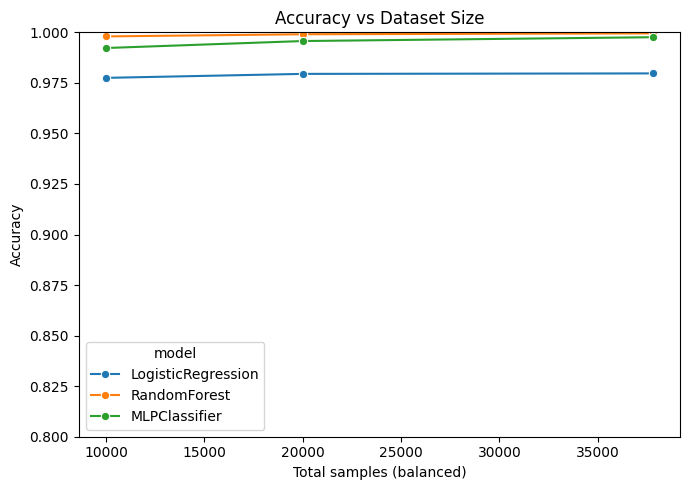

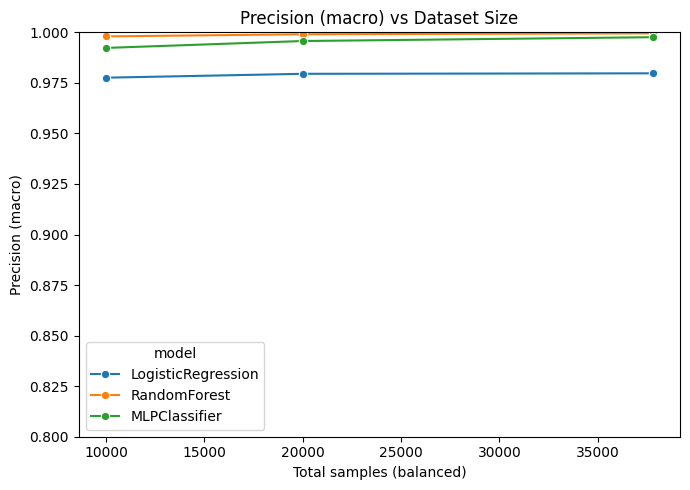

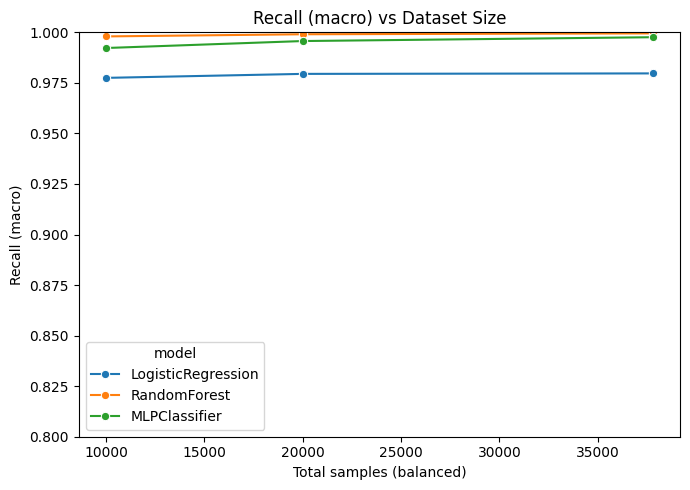

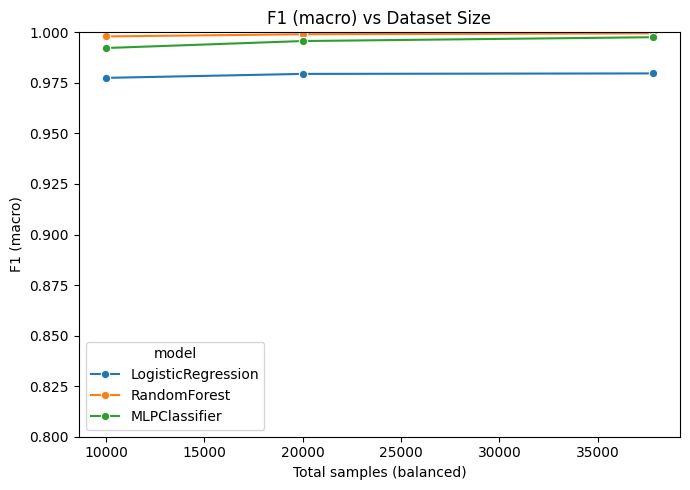

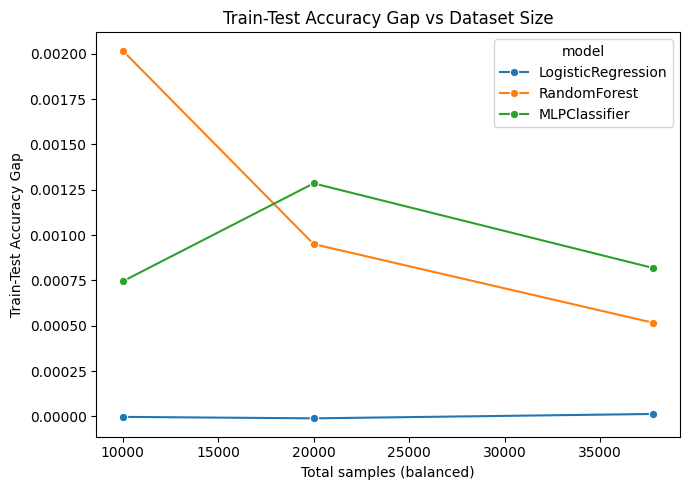

In [ ]:
logreg_results = [eval_size_logreg(n) for n in sizes]
rf_results = [eval_size_rf(n) for n in sizes]
mlp_results = [eval_size_mlp(n) for n in sizes]

def_log = pd.DataFrame(logreg_results)
def_log["model"] = "LogisticRegression"

def_rf = pd.DataFrame(rf_results)
def_rf["model"] = "RandomForest"

def_mlp = pd.DataFrame(mlp_results)
def_mlp["model"] = "MLPClassifier"

df_plot  = pd.concat([def_log, def_rf, def_mlp], ignore_index=True)

plot_dir = Path("../../Main_plts/supervidesed_models")
plot_dir.mkdir(parents=True, exist_ok=True)



metrics = ["cv_acc_mean", "cv_prec_mean", "cv_rec_mean", "cv_f1_mean",
           "test_acc", "test_prec", "test_rec", "test_f1"]
titles = {
    "cv_acc_mean": "CV Accuracy (mean)",
    "cv_prec_mean": "CV Precision (macro)",
    "cv_rec_mean": "CV Recall (macro)",
    "cv_f1_mean": "CV F1 (macro)",
    "test_acc": "Test Accuracy",
    "test_prec": "Test Precision (macro)",
    "test_rec": "Test Recall (macro)",
    "test_f1": "Test F1 (macro)"
}
for m in metrics:
    plt.figure(figsize=(7, 5))
    sns.lineplot(data=df_plot, x="size", y=m, hue="model", marker="o")
    plt.title(f"{titles[m]} vs Dataset Size")
    plt.xlabel("Total samples (balanced)")
    plt.ylabel(titles[m])
    if m != "acc_gap":
        plt.ylim(0.8, 1.0)
    plt.tight_layout()
    plt.savefig(plot_dir / f"{m}_vs_size.png", dpi=200, bbox_inches="tight")
    plt.show()
    plt.close()



## Confusion Metrics


              precision    recall  f1-score   support

    exo_host       1.00      1.00      1.00      2520
      quasar       1.00      1.00      1.00      2520
        star       1.00      1.00      1.00      2520

    accuracy                           1.00      7560
   macro avg       1.00      1.00      1.00      7560
weighted avg       1.00      1.00      1.00      7560



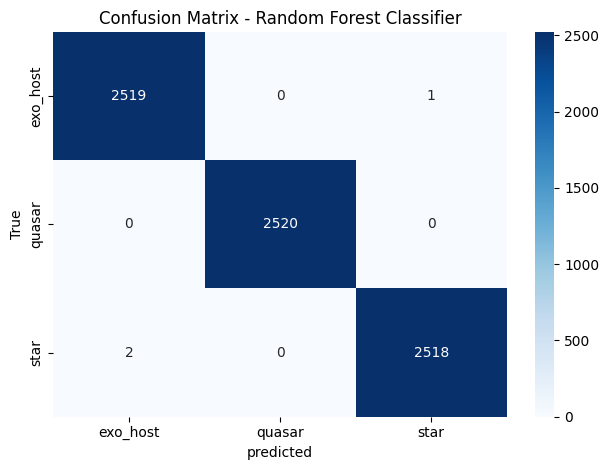

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


# Using largest dataset size
n_total = 37800
n_per = min(n_total // 3, len(stars), len(exo), len(quasars))

stars_sub = stars.sample(n=n_per, random_state=42)
exo_sub = exo.sample(n=n_per, random_state=42)
quasars_sub = quasars.sample(n=n_per, random_state=42)

# Combine subsets
df = pd.concat([stars_sub, exo_sub, quasars_sub], ignore_index= True)

X = df[features].values
y = df["label"].values


# train-test, split the dataset
#80% train/20% tets
#sratify=y keeps class balance
X_train, X_test, y_train, y_test = (train_test_split(X, y, stratify=y, test_size=0.2, random_state=42))


#Randopm Frest Classifier
#300 trees, random state for reproducibility, balanced sampling inside each tree
clf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced_subsample")

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

# Confusion Matrix  (true vs predicted values)
cm  = confusion_matrix(y_test, y_pred, labels=np.unique(y))

#set up the matplotlib figure (Drawing the confusion matrix as a colored grid with numbers)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))

#Adding lables and title 
plt.title("Confusion Matrix - Random Forest Classifier")
plt.xlabel("predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

